# It's a Start

### Imports

In [85]:
import copy
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt

### Fixed realities of the workday

The café is open for 9 hours, say 6:30 to 15:30. Two hours into the day, then starting at circa 08:30, is what one would call a "rush hour". As a baseline, the café gets around 6 customers per hour. During the rush hour, this number can rise to around 30 customers per hour.

In [86]:
HOURS_SIMULATED = 9     # The café is open for 9 hours.
CLOSES = 540            # The simulation ends after those 9 hours and not a minute later.
OPEN_FOR = 525          # They'll stop serving new customers 8.75 hours in, that's 15 minutes before officially closing the shop.
                        # This should give them time to finish any orders they were working on and close up the café.

def arrival_rate(time):
    '''
    Arrival rate in customers per --> minute <--.
    Should peak at around 120 minutes in, that's 08:30.

    arrival_rate(t) = baseline + ( peak * gaussian_bump(t) )
    '''

    baseline    = 6/60      # 6 customers per hour as the baseline.
    peak        = 30/60     # 30 customers per hour at peak hours.
    rush        = 120       # That's 2 hours into the day. 
    rush_length = 60        # Length of rush hour (1 hour).

    return (baseline +   (peak *   (np.exp(-((time-rush)**2) / (2*(rush_length**2))))   )   )

To better visualize this arrival rate, we've prepared a graph.

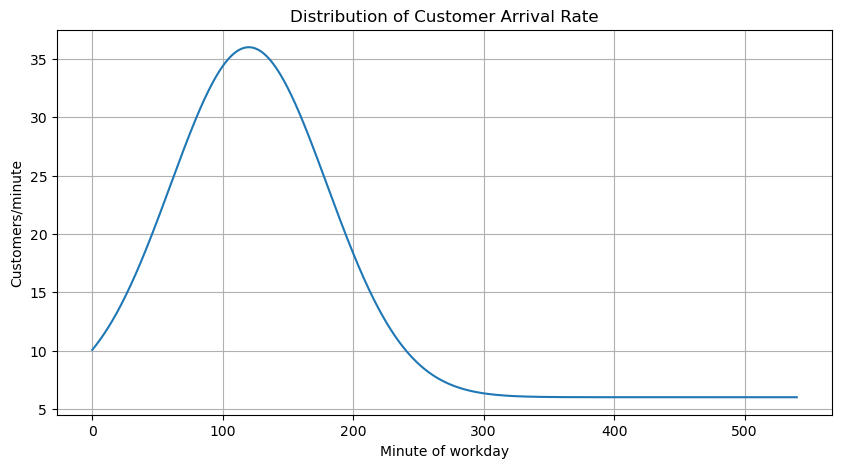

In [87]:
t = np.linspace(0, 540, 1000)   # 9 hours, 1000 points (smooth).

rate = (arrival_rate(t) * 60) # *60 since the arrival_rate returns the arrival rate in minutes. 

plt.figure(figsize=(10,5))
plt.plot(t, rate)
plt.xlabel("Minute of workday")
plt.ylabel("Customers/minute")
plt.title("Distribution of Customer Arrival Rate")
plt.grid(True)
plt.show()

That's the overarching arrival rate, with the rush hour peaking at around 08:30.

The inter-arrival rate (that is, the distribution of the time between arrivals) is exponential, with $ʎ(t)$ = arrival rate at time $t$, and mean inter-arrival time(t) = $1 / ʎ(t)$.

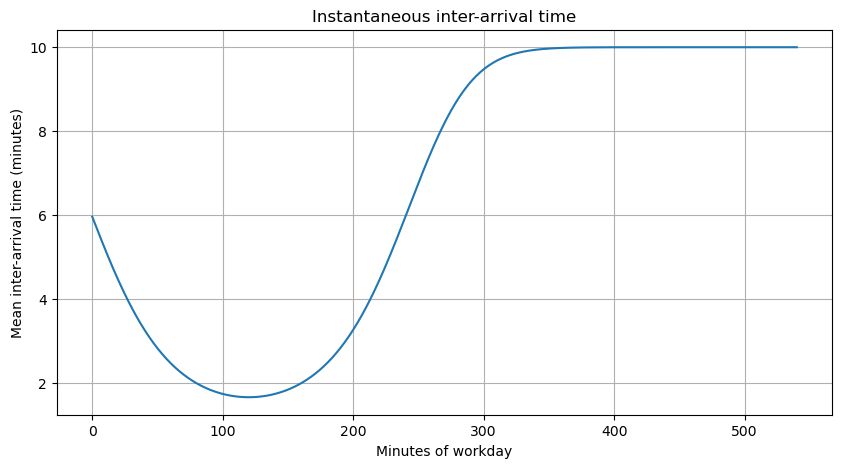

In [88]:
t = np.linspace(0, 540, 1000)
interarrival = 1 / arrival_rate(t)
plt.figure(figsize=(10,5))
plt.plot(t, interarrival)
plt.title("Instantaneous inter-arrival time")
plt.xlabel("Minutes of workday")
plt.ylabel("Mean inter-arrival time (minutes)")
plt.grid(True)
plt.show()

This doesn't illustrate much that hasn't already been illustrated, but shows clearly that circa 10 minutes will pass on average between customers during the baseline (6 customers in 60 minutes) and circa 2 minutes will pass between customer arrivals during the worst of the rush hour.

### Other Global Variables

Notably, we're normalizing everything to SimPy time units = minutes. For the sake of avoiding confusion and ensuring consistency, we will wisely also define seconds, minutes and hours in this context.

* Note that every function that returns a duration should return said value in *minutes*.

Additionally, there are some variables which should be hard-coded in the system. For example, the chance that a coffee machine needs to be utilized in order to complete an order could be something like 90%. In the same vein, the likelihood that an oven needs to be used to complete an order (to heat up a cinnamon bun, or something like that) could be 15%.

The "default variables" for simulations should also be defined here for the sake of good organization. 

The default schedule is:

|           | Shift 1 | Shift 2 | Shift 3 | Shift 4 | Shift 5 | Shift 6 | Shift 7 | Shift 8 | Shift 9 |
| --------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| Registers | 1       | 1       | 1       | 1       | 1       | 1       | 1       | 1       | 1       |
| Baristas  | 2       | 2       | 2       | 2       | 2       | 2       | 2       | 2       | 2       |

This is the café's current schedule, three people on site at all hours. 

The number of machines that their baristas have access to is:

| Coffee Machines | Ovens |
| --------------- | ----- |
| 1               | 1     |

The café owners have also determined that no more than 5 staff members can fit into the same shift, as there is simply not enough space behind the counter. No more than 2 of those can man the registers, as there is not enough physical space to fit more than 2 registers. This means that at maximum a shift could hold either 2 registers and 3 baristas or 1 register and 4 baristas. At minimum, a shift would need at least 1 register and 1 barista as one worker of each kind is needed for the system to function.

In [89]:
# TIME-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - - - - - - -  
SECONDS = 1/60
MINUTES = 1
HOURS = 60

# LIKELIHOOD-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - - - -  
CHANCE_THAT_COFFEE_MACHINE_NEEDED = 0.9
CHANCE_THAT_OVEN_NEEDED = 0.15

# SHIFT-CONSTRAINT-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - 
NUM_TOTAL_STAFF_THAT_FIT_BEHIND_COUNTER = 5
NUM_REGISTERS_THAT_FIT = 2

# DEFAULT NUMBER GLOBALS - - - - - - - - - - - - - - - - - - - - - - - - - 
DEFAULT_NUM_REGISTERS       = 1
DEFAULT_NUM_BARISTAS        = 2 
DEFAULT_NUM_PICKUP_STATIONS = 1 # TODO: We'll take this out at some point. 
DEFAULT_NUM_COFFEE_MACHINES = 1 
DEFAULT_NUM_OVENS           = 1 

The concept of shifts may now be in your recent memory, as it was previously explained that the default for any shift is to have one person at the register and two persons preparing orders. It's worth elaborating on this concept of shifts, as they are one of the variables we will be playing around with.

The café's schedule is made up of shifts. To simplify things, we will make "shifts" synonymous with "hours". That means that 9 different shifts are available in the day, each an hour long. Like so:

| Hour 1 | Hour 2 | Hour 3 | Hour 4 | Hour 5 | Hour 6 | Hour 7 | Hour 8 | Hour 9 |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| Shift 1 | Shift 2 | Shift 3 | Shift 4 | Shift 5 | Shift 6 | Shift 7 | Shift 8 | Shift 9 |

The number of baristas or registers scheduled to be working can change between shifts, but the aforementioned constraints still apply to each and every one of these shifts.

* We must have at least 1 barista and 1 person at the register scheduled for each shift. This is the minimum amount of staff we need for the system to function.
* No more than 2 people can be at the register on any shift, as only 2 actual registers can fit into the space.
* No mpre than 5 people can be expected to fit behind the counter at once.

In [90]:

class Shifts:
    def __init__(self, default_num_registers=1, default_num_baristas=1):
        '''
        The default value for each shift is 1 register and 1 barista, 
        the minimum amount of staff needed for the system to function.

        I also added easy-to-use functions to increase or decrease the count of staff in any shift.
        
        shifts.add_register_to_shift(shift=1, count=1)      --> adds 1 register to shift 1.
        shifts.add_register_to_shift(shift=1, count=2)      --> adds 2 registers to shift 1.
        shifts.remove_register_from_shift(shift=1, count=1) --> removes 1 register from shift 1.

        Each time you modify a shift, the shift automatically gets validated according to the constraints we set 
        (no more than 5 people can fit behind the counter and no more than 2 registers can fit in the space).
        If the shift is not valid, the function will return False.
        If it's valid, then it'll return True and you're free to move on.
        '''

        # If the inputs weren't valid, we return an error.
        validate_inputs = [default_num_registers, default_num_baristas]
        if not self._validate_shift(validate_inputs):
            raise ValueError(f"Invalid initial values: registers={default_num_registers} and baristas={default_num_baristas}.")

        # Else, we put this --> {HOURS_SIMULATED} <-- many identical shifts into a list.
        self.shifts = [[default_num_registers, default_num_baristas] for _ in range(HOURS_SIMULATED)]
        
    def _validate_shift(self, shift):

        # Are there at least one register and one barista?
        if ((shift[0] < 1) or (shift[1] < 1)):
            return False
        
        # Are there more than 5 people behind the counter?
        if ((shift[0] + shift[1]) > NUM_TOTAL_STAFF_THAT_FIT_BEHIND_COUNTER):
            return False
        
        # Are there more registers here than available? 
        if (shift[0] > NUM_REGISTERS_THAT_FIT):
            return False
        
        return True
    
    def _add_employee_to_shift(self, shift_nr, count, employee_type):
        shift = self.shifts[shift_nr - 1]
        shift[employee_type] += count

        if (self._validate_shift(shift)):
            return True
        else:
            shift[employee_type] -= count
            return False
        
    def _remove_employee_from_shift(self, shift_nr, count, employee_type):
        shift = self.shifts[shift_nr - 1]
        shift[employee_type] -= count

        if (self._validate_shift(shift)):
            return True
        else:
            shift[employee_type] += count
            return False
        
    def _add_employee_to_every_shift(self, count, employee_type):
        for shift in self.shifts:
            shift[employee_type] += count

        # If this was a valid action:
        if (all(self._validate_shift(shift) for shift in self.shifts)):
            return True

        # If this was not a valid action:
        for shift in self.shifts:
            shift[employee_type] -= count

        return False
    
    def _remove_employee_from_every_shift(self, count, employee_type):
        for shift in self.shifts:
            shift[employee_type] -= count

        # If this was a valid action:
        if (all(self._validate_shift(shift) for shift in self.shifts)):
            return True

        # If this was not a valid action:
        for shift in self.shifts:
            shift[employee_type] += count

        return False

    def add_register_to_shift(self, shift_nr, count):
        return self._add_employee_to_shift(shift_nr, count, 0)

    def add_barista_to_shift(self, shift_nr, count):
        return self._add_employee_to_shift(shift_nr, count, 1)

    def remove_register_from_shift(self, shift_nr, count):
        return self._remove_employee_from_shift(shift_nr, count, 0)

    def remove_barista_from_shift(self, shift_nr, count):
        return self._remove_employee_from_shift(shift_nr, count, 1)
    
    def add_register_to_every_shift(self, count):
        return self._add_employee_to_every_shift(count, 0)

    def add_barista_to_every_shift(self, count):
        return self._add_employee_to_every_shift(count, 1)
    
    def remove_register_from_every_shift(self, count):
        return self._remove_employee_from_every_shift(count, 0)

    def remove_barista_from_every_shift(self, count):
        return self._remove_employee_from_every_shift(count, 1)



This structure should hopefully help keep things clear and organized when it comes to the matter of experimentation. 

It's worth noting that, in SimPy, a resource that's created with a certain capacity cannot have its capacity spontaneously "updated" or "adjusted". This makes implementing the change in resource capacities between shifts a tad tricky. This will be done with the aide of a store or sorts. Thus, we define a "shift_manager" to aide in the transition between shifts.

In [91]:
def adjust_staff(role, count, current, pool, hour):
    '''
    shift_manager's helper.
    Adjusts the staff count for the given role at shift change.

    - role:         Str.        "register" or "barista".
    - count:        Int.        Scheduled staff count at this hour.
    - current:      Int.        Current staff count in the shift record
    - pool:         Store.      Pool of staff.
    - hour:         Int.        Current simulation hour.
    '''

    # If we need more staff:
    if (count > current):
        for _ in range(count - current):
            yield pool.put(f"{role}_{hour}")

    # If we need less staff:
    elif (count < current):
        # Note that we're only removing staff that's free. We won't remove someone when they're in the middle of making an order. We'll let them finish.
        remove_count = (current - count)
        for _ in range(remove_count):
            if len(pool.items) > 0:
                yield pool.get()

    # And if we already have the correct amount of staff, nothing changes.
    else:
        pass


def shift_manager(env, shifts, register_pool, barista_pool, current_shift):
    '''
    Every hour, updating the number of registers and baristas according to schedule.
    
    NOTE: shift.shifts[hour] = [# registers, # baristas]
    '''

    registers_scheduled, baristas_scheduled = shifts.shifts[0]
    current_shift["registers"] = registers_scheduled
    current_shift["baristas"] = baristas_scheduled

    hour = 1
    while (hour < HOURS_SIMULATED):

        yield env.timeout(60) # The shift passes (1 hour, always).

        registers_scheduled, baristas_scheduled = shifts.shifts[hour]

        # - - - - - REGISTERS - - - - -

        yield from adjust_staff(
            role="register",
            count=registers_scheduled,
            current=current_shift["registers"],
            pool=register_pool,
            hour=hour
        )
        current_shift["registers"] = registers_scheduled

        # - - - - - BARISTAS - - - - -

        yield from adjust_staff(
            role="barista",
            count=baristas_scheduled,
            current=current_shift["baristas"],
            pool=barista_pool,
            hour=hour
        )
        current_shift["baristas"] = baristas_scheduled

        # - - - ... and the shift passes. - - - 
        hour += 1 


The "register_pool" and "barista_pool" are both SimPy "Store" resources. That is, Register and Barista resources are stored in these "pools", respectively. A staff member can then be aquired with "{staff_type} = yield {staff_type}_pool.get()". 

Every hour, the shift manager adjusts the schedule such that we'll have the scheduled amount of each employee. It's worth noting that each employee will "finish what they were doing" (in a sense) before "leaving their shift". The shift_manager only shoos away those employees currently idle when the shift changes, the employees finishing a task will simply not be available anymore after they finish what they were doing.



### Metrics to track

The purpose of simulating this process is to minimize the waiting time for customers while maximizing resource utilization. There are several related metrics worth keeping track of, including:
1) Customer waiting time.
    - From when the customer arrives to the cafe to when their order is ready, how much did they have to wait?
    - Aside from the total wait time, it's also possible to split their wait into three sections:
        1) Waiting in line.
        2) Making their order. <-- not really "waiting" if they're actively doing something. Should we still include this in the total?
        3) Waiting while their order is prepared.
2) Resource busy/idle time.
    - Uhhhhh *we'll fill this in once that part of the code is ready.

It's also a good idea to keep track of more general things, such as:
- Number of customers.
- How long from when an order is placed until preparation begins?
- *we may think of other things. Maybe queue lengths? I could see that maybe being marginally helpful.

In [92]:
class Stats:
    '''A class to keep track of the numbers for each simulation.'''

    def __init__(self):
        # CUSTOMER TIME-TRACKING
        self.register_queue_time = []           # Time each customer spent waiting to place their order.
        self.pickup_queue_time = []             # Time each custimer spent picking up their order.
        self.total_time_in_system = []          # Total time each customer spent from arrival time to pickup time.
        
        self.time_until_prep_begins = []        # The time from the customer places the order until a barista begins working on it.

        self.arrival_times = []                 # For plotting.

        # OTHER CUSTOMER-RELATED MEASURES
        self.num_customers = 0
        self.avg_length_register_queue = []     # This is a list because we might also want to graph this. Average length of queue per every hour, or something.
        self.avg_length_pickup_queue = []       # I don't think this has ever not been 0. I'm tracking it for the sake of consistency, though.
        self.avg_count_customers_waiting = []   # Could also be cool to graph.

        # TODO: RESOURCE UTILIZATION


### Time distributions defined

*Insert text on time distributions.

Note that these should all return the time in minutes.

In [93]:
def order_time(rng):
    '''How long it takes a customer to order, in minutes.'''
    
    sample = 10 + rng.gamma(5, 11)      # Shape=5, scale=11, then +10 sec base.
    return min(sample, 120) * SECONDS   # Hard max cutoff: 2 minutes = 120 seconds.

 
def making_order_time(rng):
    '''How long it takes to get the order ready.
    TODO: We might want to change this process later, add coffe machines and such as resources, and so on.
    For now though, it's just a distribution like so.'''

    # Triangular distribution: min=15s, mode=3min, max=10min.
    return rng.triangular(15, 3*60, 10*60) * SECONDS


# TODO: This will not remain.
# It's gotta take at least a second.
# I'm just going to be optimistic and guess that the mean is 5 seconds, and the std is 1.
def pickup_time(rng):
    '''How long it takes the customer to pick up the order.'''
    return max(1, rng.normal(5, 1)) * SECONDS


# Uniform distribution, minimum 0.5 minutes and maximum 2 minutes.
def coffee_machine_time(rng):
    '''How long it takes the barista to use the coffee machine for a given order.'''
    return rng.uniform(low=30, high=120) * SECONDS


# Uniform distribution, minimum 1 minute maximum 5 minutes (just to heat things up).
def oven_time(rng):
    '''How long it takes the barista to use the oven for a given order.'''
    return rng.uniform(low=60, high=300) * SECONDS

### Helpers

In [94]:
def use_coffee_machine(env, ID, coffee_machine, rng):
    '''If a barista needs to use a coffee machine, this function will run.'''

    with (coffee_machine.request() as req):
        yield req
        time = coffee_machine_time(rng)
        #print(f"{ID} using coffee machine for {time:.2f} seconds at {env.now:.2f}.")
        yield env.timeout(time)

def use_oven(env, ID, oven, rng):
    '''If a barista needs to use an oven, this function will run.'''

    with (oven.request() as req):
        yield req
        time = oven_time(rng)
        #print(f"{ID} using oven for {time:.2f} seconds at {env.now:.2f}.")
        yield env.timeout(time)

Baristas may well need to use a coffee machine or an oven to finish a given order. These actions are placed in their own functions primarily for increased ease of readibility later in the file.

In [95]:
def print_stats(statistics):
    '''The stats for each simulation run on a printed format.'''

    print("# Customers:", statistics.num_customers)
    print("Total times in register queue:\n", statistics.register_queue_time)
    print("Time from when the order is placed until a barista begins working on it:\n", statistics.time_until_prep_begins)
    print("Total times in pickup queue:\n", statistics.pickup_queue_time)
    print("Total times in system:\n", statistics.total_time_in_system)
    # *More.

# TODO: I assume we'll make more functions for calculating and printing and such when we're at the stage of actually doing experiments.

*Insert text discussing the code cell above.

In [96]:


def plot_stats(statistics):
    '''To avoid repeating ourselves.'''

    plt.plot(statistics.total_time_in_system)
    plt.ylabel('Waiting time for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()
    
    plt.plot(statistics.register_queue_time)
    plt.ylabel('Waiting time in register queue for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()
    
    plt.plot(statistics.pickup_queue_time)
    plt.ylabel('Waiting time in pickup queue for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()
    
    plt.plot(statistics.time_until_prep_begins)
    plt.ylabel('Waiting time until barista begins working on order for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()

def plot_arrivals(statistics):
    '''Plots arrivals as a scatter plot + rate histogram.'''

    arrivals = statistics.arrival_times
    
    plt.figure(figsize=(10,4))

    # Scatter plot:
    plt.scatter(arrivals, [0]*len(arrivals), s=10)
    plt.title("Arrivals Scatter Plot")
    plt.xlabel("Time (minutes)")
    plt.yticks([])
    plt.show()

    # Histogram:
    plt.figure(figsize=(10,4))
    plt.hist(arrivals, bins=30)
    plt.xlabel("Time (minutes)")
    plt.ylabel("# Arrivals")
    plt.title("Arrivals Histogram")
    plt.show()

# TODO: Should add plots for resource utilization as well.

Several things will be plotted for ease of analysing the results. For instance, the waiting time for each customer will be graphes so we can see visually whether customers are waiting longer at any single period of time, or whether the waiting time may be increasing or decreasing as the day goes on.

### Meatier functions

In [97]:

def customer(env, stats_keeper, ID, register_pool, barista_pool, pickup, coffee_machine, oven, rng, current_shift):
    '''
    Customer's "lifecycle".
    A customer arrives to wait in line, orders + pays, waits while a barista prepares their order, and then pick up their order when it's ready.
    
    Note that the baristas may also use resources such a coffee machine or oven, and the availability of such devices affects the customer's waiting time.
    
    Params:
        - env:              simpy.Environment.  The environment of this current run.
        - stats_keeper:     Stats.              Used for collecting stats on the simulation run.
        - ID:               Int.                The customer's ID.
        - register_pool:    simpy.Store.        Stores registers, which are of the type simpy.Resource.
        - barista_pool:     simpy.Store.        Stores baristas, which are of the type simpy.Resource.
        - pickup:           simpy.Resource.     The spot where you pick up your drink.
        - coffee_machine:   simpy.Resource.     The baristas likely need to use it to prepare your order.
        - oven:             simpy.Resource.     The baristas may need to use it to prepare your order.
        - rng:              Generator.          A random number generator (RNG).
        - current_shift:    Int.                The number of the hour.
    '''

    arrival = env.now
    #print(f'{ID} arrives at {arrival:.2f}')
    stats_keeper.num_customers += 1

    # TODO: I could refactor these "acts" into different function. For readibility. 

    # # # # # # # # # # # # # # 
    #   ACT I: The Register   #
    # # # # # # # # # # # # # # 
    register = yield register_pool.get() # Acuiring staff member.
    
    start_ordering = env.now
    #print(f"{ID} begins ordering at {start_ordering:.2f}")
    ordering = order_time(rng)
    yield env.timeout(ordering) # We wait while the customer places their order.
    
    stop_ordering = env.now
    #print(f"{ID} finishes ordering at {stop_ordering:.2f}")

    # Releasing staff member:
    yield register_pool.put(register)

    # # # # # # # # # # # # # # 
    #   ACT II: The Waiting   #
    # # # # # # # # # # # # # # 
    # The barista may need to #
    # use the coffee machine  #
    # and/or oven to complete #
    # the order, and on top   #
    # of that some time gets  #
    # added.                  #
    # # # # # # # # # # # # # # 

    barista = yield barista_pool.get()
    prep_begin = env.now
    #print(f"{ID}'s order preperation begins at {prep_begin:.2f}")

    # The time it takes to get an order ready is:
    #
    #       time using coffee machine   Distribution: Uniform
    #   +   time using oven             Distribution: Uniform
    #   +   general prep time           Distribution: Triangle
    #   =   total time                  Distribution: Looks a bit sillier

    needs_coffee =  rng.random() < CHANCE_THAT_COFFEE_MACHINE_NEEDED
    needs_oven =    rng.random() < CHANCE_THAT_OVEN_NEEDED
    
    if (needs_coffee):
        yield env.process(use_coffee_machine(env, ID, coffee_machine, rng))
    if (needs_oven):
        yield env.process(use_oven(env, ID, oven, rng))

    prep_time = making_order_time(rng)
    yield env.timeout(prep_time)

    # - - - - - - - - - - Order finished! - - - - - - - - - -

    time_ready = env.now
    #print(f"{ID}'s is ready for pickup at {time_ready:.2f}")

    # The barista then leaves if their shift is over.
    if (len(barista_pool.items) < current_shift["baristas"]):
        yield barista_pool.put(barista)
    else:
        #print(f"Barista finishes and goes off shift at {env.now:.2f}")
        pass

    # # # # # # # # # # # # # # 
    #   ACT III: The Pickup   #
    # # # # # # # # # # # # # #
    with pickup.request() as req:
        yield req

        start_pickup = env.now
        #print(f"{ID} goes to pick up their order at {start_pickup:.2f}")

        pickupp_time = pickup_time(rng)
        yield env.timeout(pickupp_time)

        end_time = env.now
        #print(f"{ID} leaves at {end_time:.2f}")

    # # # # # # # # # # # # # # #
    #   ALSO: Gathering Stats   #
    # # # # # # # # # # # # # # #

    time_in_register_queue  = max(0, (start_ordering - arrival))
    time_in_pickup_queue    = max(0, (time_ready - start_pickup))
    total_time              = max(0, (end_time - arrival))

    stats_keeper.register_queue_time.append(time_in_register_queue)
    stats_keeper.pickup_queue_time.append(time_in_pickup_queue)
    stats_keeper.total_time_in_system.append(total_time)

    time_from_order_to_prep_start = max(0, (time_ready - prep_begin))
    stats_keeper.time_until_prep_begins.append(time_from_order_to_prep_start)


Here the customer's "lifecycle" is simulated. After the customer arrives at the café, they'll wait in line (unless the line is empty, in which case they'll march right up to the register), they'll order, and then they'll wait until their order is ready. We care only about what happens before the customer receives their drink, and thesefore do not simulate the customer leaving the café or finding a seat.

In [98]:

def arrivals_generator(env, stats_keeper, register_pool, barista_pool, pickup, coffee_machine, oven, arrival_rate, current_shift, seed=None):
    '''
    Generates arrivals of customers according to the chosen arrival_rate.
    Runs the 'customer' process for each of the arrivals.

    Params:
        - env:              simpy.Environment.  The environment of this current run.
        - stats_keeper:     Stats.              Used for collecting stats on the simulation run.
        - register_pool:    simpy.Store.        Stores registers, which are of the type simpy.Resource.
        - barista_pool:     simpy.Store.        Stores baristas, which are of the type simpy.Resource.
        - pickup:           simpy.Resource.     The spot where you pick up your drink.
        - coffee_machine:   simpy.Resource.     The baristas likely need to use it to prepare your order.
        - oven:             simpy.Resource.     The baristas may need to use it to prepare your order.
        - arrival_rate:     A function.         Returns the "customers per minute" arrival rate based on the the current time.
        - current_shift:    Int.                The number of the hour.
        - seed:             int.                Seed for a random number generator.
    '''

    rng = np.random.default_rng(seed)

    customer_ID = 0
    inter_arrival = 0
    while True:

        if ((env.now + inter_arrival) >= OPEN_FOR):
            #print(f"\nCLOSING SHOP. \nNo more arrivals after closing at {OPEN_FOR:.2f}.\n")
            return

        rate = arrival_rate(env.now)
        inter_arrival = rng.exponential(1 / rate)       # Inter arrival from exponential dist.
        yield env.timeout(inter_arrival)                # Waiting until the next arrival.

        arrival_time = env.now                          # For plotting.
        stats_keeper.arrival_times.append(arrival_time)

        env.process(customer(
            env,
            stats_keeper,
            customer_ID,
            register_pool,
            barista_pool,
            pickup,
            coffee_machine,
            oven,
            rng,
            current_shift
        ))
        customer_ID += 1

The arrivals_generator, living up to its name, generates customer arrivals. 

It's worth repeating that the café stops serving new customers at {OPEN_FOR} minutes into the day, and the simulation itself ends at {CLOSES}. The employees should ideally be able to finish up any orders before closing up for the day.

In [99]:
def simulate(shifts, num_pickups, num_coffee_machines, num_ovens, arrival_rate, ttl):
    '''
    Simulates the process with the specified:
        - shifts:               Shifts.     Contained the scheduled shifts.
        - num_pickups:          Int.        Number of places where drinks can be picked up.
        - num_coffee_machines:  Int.        Number of coffee machines which baristas have at their disposal.
        - num_ovens:            Int.        Number of ovens which baristas have at their disposal.
        - arrival_rate:         Function.   Returns the arrival rate in customers per minute.
        - ttl:                  Float.      "time-to-live", how long the simulation will be allowed to run (in case there are some customers still awaiting their orders).

    Returns:
        - statistics:           Stats.  The numbers for this particular simulation run.
    '''
    
    env = simpy.Environment()
    statistics = Stats()

    #register = simpy.Resource(env, capacity=num_registers)      # Note: SimPy resources are FIFO by default.
    #barista = simpy.Resource(env, capacity=num_baristas)        # We have [CAPACITY] amount of baristas, each can focus on one order at a time.

    # < - - - STAFF POOLS - - - >
    # TODO: The number of available resources depends on which shift we're on. (Shift == hour)
    register_pool = simpy.Store(env)
    barista_pool  = simpy.Store(env)
    # So instead of changing the capacity of resources (which isn't possible) we use a store to hold staff objects. We can then add and remove thse objects at shift changes.

    # Initializing shift 1 staff:
    first_shift_num_registers, first_shift_num_baristas = shifts.shifts[0]
    for i in range(first_shift_num_registers):
        register_pool.put(f"register_0")
    for i in range(first_shift_num_baristas):
        barista_pool.put(f"barista_0")

    pickup = simpy.Resource(env, capacity=num_pickups)
    coffee_machine = simpy.Resource(env, capacity=num_coffee_machines)
    oven = simpy.Resource(env, capacity=num_ovens)

    # This is to track the current shift's capacity.
    current_shift = {
        "registers": first_shift_num_registers,
        "baristas": first_shift_num_baristas
    }

    # Starting the shift manager:
    # def shift_manager(env, shifts, register_pool, barista_pool, current_shift)
    env.process(shift_manager(env, shifts, register_pool, barista_pool, current_shift))

    # Starting the arrivals:
    env.process(arrivals_generator(
        env=env, 
        stats_keeper=statistics,
        register_pool=register_pool,
        barista_pool=barista_pool,
        pickup=pickup,
        coffee_machine=coffee_machine,
        oven=oven,
        arrival_rate=arrival_rate,
        current_shift=current_shift,
        seed=360
    ))
    env.run(until=ttl)

    return statistics


def run_simulations(e):
    '''Run the simulation several times.'''
    nr_runs = e.num_of_simulations

    # TODO: Introduce randomness, so that the results don't look the same for each run.
    for i in range(0, nr_runs):
        stats = simulate(e.shifts, e.num_pickups, e.num_coffee_machines, e.num_ovens, e.arrival_rate, e.ttl)

        # TODO: And I assume we do something with the stats here. Compile them or work something out of them.

    return True # TODO: ... and we might want to return something, or print something, or graph something.


As the plan is to simulate this corner of the workday several times, both with the default values and with many experimental changes, we found it necessary to have a function which runs one single simulation, as well as one that runs several simulations with the same parameters.

## The Experimental Setup

| Understaffing | Average staffing | High staffing | Full staffing |
| ------------- | ---------------- | ------------- | ------------- |
| (1,1)         | (1,2)            | (1,3)         | (2,3)         |

For our main experiments, the staffing will remain the same throughout most of the day but will be changed during the rush hour period. We will try average staffing, high staffing and full staffing, but  will be skipping understaffing as we already know it will not suffice.

For each of these scenarios, we will additionally be testing different numbers of machinery.

| Coffee Machine | Oven |
| -------------- | ---- |
| 1              | 1    |
| 1              | 2    |
| 2              | 1    |
| 2              | 2    |

In [100]:

# The shifts are automatically set to 1 register and 1 barista for every shift (the bare minimum). 
# The "original" shifts at this café consisted of 1 register and 2 baristas at all hours.
DEFAULT_SHIFTS = Shifts()
ORIGINAL_SHIFTS = copy.deepcopy(DEFAULT_SHIFTS)
ORIGINAL_SHIFTS.add_barista_to_every_shift(1) 

# TODO: Change to something else. Or don't. 
DEFAULT_NUM_SIMULATIONS = 30

class Experiment:
    '''A class  representing a single experiment.'''

    def __init__(self):
        self.num_of_simulations     = DEFAULT_NUM_SIMULATIONS       # Whatever number we've decided will suffice.
        self.shifts                 = DEFAULT_SHIFTS                # The minimum amount of staff needed for the system to function is 1 register and 1 barista.
        self.num_pickups            = DEFAULT_NUM_PICKUP_STATIONS   # TODO: We are still considering removing this, right?
        self.num_coffee_machines    = DEFAULT_NUM_COFFEE_MACHINES   # 1 by default.
        self.num_ovens              = DEFAULT_NUM_OVENS             # 1 by default.
        self.arrival_rate           = arrival_rate                  # The customer arrival rate.
        self.ttl                    = CLOSES                        # The simulation ends after {CLOSES} minutes.


## Experiments

*A few words.

### Experiment 0: Original Setup

The café currently has 1 register and 2 baristas working during all shifts, and has 1 coffee machine and 1 oven. We will run this to get a feel for how things usually are.

In [101]:
# Default values:
exp = Experiment()
exp.num_of_simulations  = DEFAULT_NUM_SIMULATIONS
exp.shifts              = ORIGINAL_SHIFTS

exp_res = run_simulations(exp)
#TODO: We'll want to return something better.


*And then we'd analyze the results here.

### Experiment 1: *Title*

*Explain:
- What the values are in this experiment.
- Why they are like that.
- The point of this experiment.
- ... anything else?

In [102]:
# Run this experiment, similar to experiment 0.

### ... and so on.

## Discussion of results

asdfghjklkjhgfdsdfghjkl